In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator

np.random.seed(25)

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print("X_train original shape", X_train.shape)
print("y_train original shape", y_train.shape)
print("X_test original shape", X_test.shape)
print("y_test original shape", y_test.shape)

('X_train original shape', (60000, 28, 28))
('y_train original shape', (60000,))
('X_test original shape', (10000, 28, 28))
('y_test original shape', (10000,))


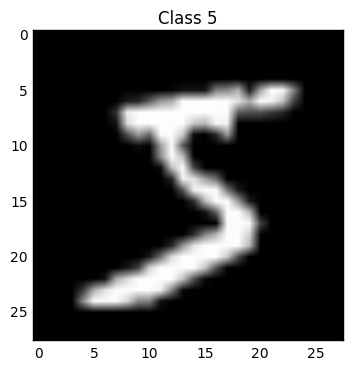

In [3]:
plt.imshow(X_train[0], cmap='gray')
plt.title('Class '+ str(y_train[0]))

In [4]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

X_train/=255
X_test/=255

X_train.shape

(60000, 28, 28, 1)

In [5]:
number_of_classes = 10

Y_train = np_utils.to_categorical(y_train, number_of_classes)
Y_test = np_utils.to_categorical(y_test, number_of_classes)

y_train[0], Y_train[0]

(5, array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]))

In [14]:
# Three steps to Convolution
# 1. Convolution
# 2. Activation
# 3. Polling
# Repeat Steps 1,2,3 for adding more hidden layers

# 4. After that make a fully connected network
# This fully connected network gives ability to the CNN
# to classify the samples

model = Sequential()

model.add(Conv2D(32, 3, 3, input_shape=(28,28,1)))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(32,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

BatchNormalization(axis=1)
model.add(Conv2D(64,3,3))
model.add(Activation('relu'))
BatchNormalization(axis=1)
model.add(Conv2D(64,3,3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
# Fully connected layer

BatchNormalization()
model.add(Dense(512))
model.add(Activation('relu'))
BatchNormalization()
model.add(Dropout(0.5))
model.add(Dense(10))

# model.add(Convolution2D(10,3,3, border_mode='same'))
# model.add(GlobalAveragePooling2D())
model.add(Activation('softmax'))

In [15]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_7 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 10, 10, 64)        18496     
_________________________________________________________________
activation_9 (Activation)    (None, 10, 10, 64)        0         
__________

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

In [17]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

In [18]:
train_generator = gen.flow(X_train, Y_train, batch_size=64)
test_generator = test_gen.flow(X_test, Y_test, batch_size=64)

In [19]:
# model.fit(X_train, Y_train, batch_size=128, nb_epoch=1, validation_data=(X_test, Y_test))

model.fit_generator(train_generator, steps_per_epoch=60000//64, epochs=5, 
                    validation_data=test_generator, validation_steps=10000//64)

Epoch 1/5
937/937 [==============================] - 233s - loss: 0.2744 - acc: 0.9132 - val_loss: 0.0394 - val_acc: 0.9866
Epoch 2/5
937/937 [==============================] - 228s - loss: 0.0921 - acc: 0.9715 - val_loss: 0.0197 - val_acc: 0.9938
Epoch 3/5
937/937 [==============================] - 229s - loss: 0.0701 - acc: 0.9789 - val_loss: 0.0192 - val_acc: 0.9937
Epoch 4/5
937/937 [==============================] - 230s - loss: 0.0613 - acc: 0.9813 - val_loss: 0.0237 - val_acc: 0.9921
Epoch 5/5
937/937 [==============================] - 236s - loss: 0.0530 - acc: 0.9835 - val_loss: 0.0173 - val_acc: 0.9943


In [20]:
score = model.evaluate(X_test, Y_test)
print()
print('Test accuracy: ', score[1])

 9984/10000 [============================>.] - ETA: 0s()
('Test accuracy: ', 0.99439999999999995)


In [34]:
predictions = model.predict_classes(X_test)

predictions = list(predictions)
actuals = list(y_test)

sub = pd.DataFrame({'Actual': actuals, 'Predictions': predictions})
sub.to_csv('./output_cnn.csv', index=False)

 9984/10000 [============================>.] - ETA: 0s

# Pseudo Labelling

In [21]:
class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.N = sum([it.n for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
        nexts = [next(it) for it in self.iters]
        n0 = np.concatenate([n[0] for n in nexts])
        n1 = np.concatenate([n[1] for n in nexts])
        return (n0, n1)

In [22]:
predictions = model.predict(X_test, batch_size=64)

predictions[:5]

array([[  3.28769151e-10,   2.99295522e-08,   2.06926131e-07,
          9.24075838e-09,   7.18354398e-09,   4.85058771e-10,
          1.04637425e-12,   9.99999523e-01,   2.50756993e-09,
          2.25051878e-07],
       [  1.67334846e-07,   5.27240672e-07,   9.99995828e-01,
          1.81840448e-07,   1.56924685e-07,   2.96385527e-10,
          2.64530726e-08,   2.90781327e-06,   1.97683192e-07,
          5.09875910e-08],
       [  3.65011857e-07,   9.99975801e-01,   1.47215144e-06,
          1.32933877e-08,   3.54724034e-06,   9.34283264e-07,
          7.08800553e-06,   9.20768798e-06,   5.04010416e-07,
          1.02410820e-06],
       [  9.99884248e-01,   9.78555192e-08,   1.89434388e-06,
          3.81437921e-08,   7.34719308e-08,   4.76373816e-06,
          8.17719992e-05,   7.49653495e-08,   1.37043380e-05,
          1.31816460e-05],
       [  4.68080641e-09,   3.85728214e-08,   4.42199095e-08,
          2.06536122e-10,   9.99880672e-01,   3.44130702e-09,
          3.19044560e-08

In [23]:
# gen = ImageDataGenerator()

batches = gen.flow(X_train, Y_train, batch_size=48)
test_batches = test_gen.flow(X_test, predictions, batch_size=16)

In [24]:
mi = MixIterator([batches, test_batches])

mi.N

70000

In [26]:
model.fit_generator(mi, steps_per_epoch=mi.N//64, epochs=5, validation_data=(X_test, Y_test))

Epoch 1/5
1093/1093 [==============================] - 272s - loss: 0.0425 - acc: 0.9877 - val_loss: 0.0192 - val_acc: 0.9940
Epoch 2/5
1093/1093 [==============================] - 282s - loss: 0.0442 - acc: 0.9874 - val_loss: 0.0186 - val_acc: 0.9938
Epoch 3/5
1093/1093 [==============================] - 272s - loss: 0.0389 - acc: 0.9890 - val_loss: 0.0212 - val_acc: 0.9937
Epoch 4/5
1093/1093 [==============================] - 267s - loss: 0.0403 - acc: 0.9885 - val_loss: 0.0230 - val_acc: 0.9937
Epoch 5/5
1093/1093 [==============================] - 307s - loss: 0.0368 - acc: 0.9895 - val_loss: 0.0208 - val_acc: 0.9936
